In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

from advopt import tasks, experiment
from advopt import grid_search

from advopt.classifier import Network, GradNetwork, RegNetwork, Dense
from advopt.classifier.nn.utils import lincapacity, logcapacity, constcapacity, min_epoches_criterion
from advopt.target.utils import combine
from advopt.target import logloss

DEVICE = 'cuda'

In [2]:
task = tasks.SwissRoll()
assert len(task.search_space()) == 1, 'This example only works for 1D search space.'

params = np.linspace(task.search_space()[0][0], task.search_space()[0][1], num=21)

clf_type = 'NN'
size = 8 * 1024

In [19]:
!rm -rf RAO

In [20]:
results = experiment(
    root = './RAO',
    metrics=['JSD-NN', 'log-pJSD-NN', 'lin-pJSD-NN'],
    optimizer=grid_search(10),
    task=task,
    budget=None,
    repeat=1,
    sample_size=1024,
    devices=['cpu'] * 4,
    progress=tqdm
)

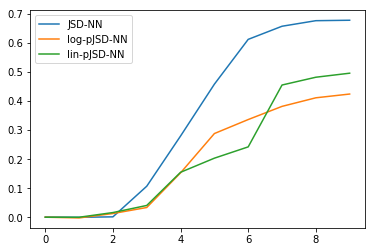

In [18]:
for name in results:
    plt.plot(results[name][0].values, label=name)

plt.legend()

In [5]:
clfs = dict()

n_control = 4
n_units = 256

penalty = 1e-3

clfs['JSD'] = Network(
    Dense(2, n0=n_units),
    stop_criterion=min_epoches_criterion(256),
    device=DEVICE
)

for i in range(n_control):
    clfs['JSD_%d' % (i + 1, )] = RegNetwork(
        Dense(2, n0=n_units),
        stop_criterion=min_epoches_criterion(256),
        penalty=penalty, capacity=constcapacity((i + 1) / n_control),
        device=DEVICE
    )

clfs['lin-pJSD'] = RegNetwork(
    Dense(2, n0=n_units),
    stop_criterion=min_epoches_criterion(256),
    penalty=penalty, capacity=lincapacity(),
    device=DEVICE
)

clfs['log-pJSD'] = RegNetwork(
    Dense(2, n0=n_units),
    stop_criterion=min_epoches_criterion(256),
    penalty=penalty, capacity=logcapacity(),
    device=DEVICE
)

In [6]:
### to obtain smooth curves we reuse the same data
### the same effect can be achieved by averaging curves over multiple runs.

data_pos = task.ground_truth_generator()(size)
data_pos_test = task.ground_truth_generator()(size)

if task.is_synthetic():
    data_neg_0 = task.ground_truth_generator()(size)
    data_neg_test_0 = task.ground_truth_generator()(size)
else:
    data_neg_0 = None
    data_neg_test_0 = None

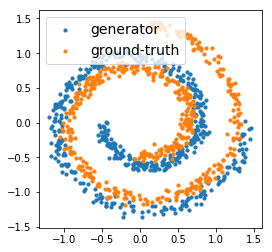

In [7]:
try:
    d_pos = task.ground_truth_generator()(size)
    d_neg = task.generator(task.example_parameters())(size)
    
    plt.figure(figsize=(4, 4))
    plt.scatter(d_neg[:512, 0], d_neg[:512, 1], label='generator', s=10)
    plt.scatter(d_pos[:512, 0], d_pos[:512, 1], label='ground-truth', s=10)
    plt.legend(loc='upper left', fontsize=14)
    plt.savefig('%s-example.pdf' % (task.name(), ))
except:
    pass

In [8]:
param, = task.example_parameters()
if task.is_synthetic():
    data_neg = task.transform(data_neg_0, [param])
    data_neg_test = task.transform(data_neg_test_0, [param])
else:
    data_neg = task.generator([param])(size)
    data_neg_test = task.generator([param])(size)

In [9]:
data, labels = combine(data_pos, data_neg)

In [10]:
grids = {
    name : clfs[name].fit(data, labels, progress=tqdm).predict_grid([(-1.75, 1.75), (-1.75, 1.75)], steps=50)
    for name in ['JSD', 'log-pJSD', 'lin-pJSD']
}

KeyboardInterrupt: 

In [ ]:
plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

for i, name in enumerate(grids):
    (xs, ys), proba = grids[name]
    
    plt.subplot(1, 3, i + 1)
    plt.contourf(xs, ys, proba)
    plt.scatter(d_neg[:512, 0], d_neg[:512, 1], label='generator', s=10)
    plt.scatter(d_pos[:512, 0], d_pos[:512, 1], label='ground-truth', s=10)
    plt.title(name)

In [ ]:
clf1 = clfs['log-pJSD']
clf2 = clfs['lin-pJSD']

In [ ]:
clf1.ce_acc

In [ ]:
clf2.ce_acc

In [ ]:
clf1.capacity(clf1.ce_acc / np.log(2))

In [ ]:
clf2.capacity(clf2.ce_acc / np.log(2))

In [ ]:
plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

for i, name in enumerate(grids):
    plt.subplot(1, 3, i + 1)
    plt.plot(clfs[name].loss_history())
    plt.title(name)

In [ ]:
divergences = {
    name : np.zeros(shape=(params.shape[0], ))
    for name in clfs
}

for i, param in enumerate(tqdm(params)):
    if task.is_synthetic():
        data_neg = task.transform(data_neg_0, [param])
        data_neg_test = task.transform(data_neg_test_0, [param])
    else:
        data_neg = task.generator([param])(size)
        data_neg_test = task.generator([param])(size)
        
    data, labels = combine(data_pos, data_neg)
    data_test, labels_test = combine(data_pos_test, data_neg_test)
    
    for name in clfs:
        clf = clfs[name]
        clf.fit(data, labels, progress=tqdm)
        proba = clf.predict_proba(data_test)
        
        divergences[name][i] = np.log(2) - np.mean(
            logloss(labels_test, proba[:, 1])
        )

In [ ]:
plt.plot(clfs['JSD'].loss_history(), )

In [ ]:
import pickle
with open('pJSD-%s-%s.pickled' % (task.name(), clf_type), 'wb') as f:
    pickle.dump(divergences, f)

In [ ]:
import pickle
with open('pJSD-%s-%s.pickled' % (task.name(), clf_type), 'rb') as f:
    divergences = pickle.load(f)

In [ ]:
plt.figure(figsize=(8, 8))
# for i in range(n_control):
#     plt.plot(params, divergences['JSD_%d' % (i + 1, )], '--', color='black')

plt.plot(params, divergences['JSD'], '-', color='black', label='JSD')

plt.plot(params, divergences['lin-pJSD'], lw=2, label='linear pJSD', color=plt.cm.tab10(0))
plt.plot(params, divergences['log-pJSD'], lw=2, label='logarithmic pJSD', color=plt.cm.tab10(1))
    
plt.legend(loc='upper left', fontsize=14, framealpha=0.95)
plt.xlabel(task.parameters_names()[0], fontsize=14)
plt.ylabel('divergence', fontsize=14)

plt.savefig('%s-%s.pdf' % (task.name(), clf_type))